# DIFFRENTS APPROACHES FOR BUILD A BINARY BIRD SOUND CLASSIFIER.

How to use?

This file is divided in 3  parts:

- DATA  (Run always all cell ans choose your approache)
- Simple approche
  - Model 2DCNN
  - Model 2DCNN - LSTM
- TL approache
  - Model TL + 2DCNN + LSTM


By : Yvan CARRE (Kyv)

# DATA

## Download data and code

You will need to authenticate with your aims.ac.za Google account. It will pop up for you and you just need to sign in.

In [3]:
colab = True

In [5]:
# This snippet of code can take up to 5 minutes or so.
# Plase allow this to complete.
if colab:
    !pip install SoundFile
    from google.colab import drive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import zipfile

    # Google Authentication
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)


    # Download code files
    downloaded = drive.CreateFile({'id':"1jm3T3OlDVQ9zAacLU18IdG-GKSDkooYk"})
    downloaded.GetContentFile('Code.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Code.zip', 'r') as zip_file:
        zip_file.extractall()


    # Download data files
    downloaded = drive.CreateFile({'id':"150iTqfC8dAsQxu0WkXZ9v8AXqomaiyWn"})
    downloaded.GetContentFile('Data.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Data.zip', 'r') as zip_file:
        zip_file.extractall()

In [ ]:
!pip install librosa==0.8.1

  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [ ]:
!pip install --upgrade librosa

  Using cached librosa-0.10.1-py3-none-any.whl (253 kB)
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


In [6]:
# Do not delete these imports
from Preprocessing import *
import librosa
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import count
import math
import pandas as pd


# Neural network things
# ---------------------
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D,ConvLSTM2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical, plot_model

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers,layers
import tensorflow.keras as keras

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


## Pre-process the data

In [ ]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser
# -----------------------------
positive_class = ['1'] # which labels should be bundled together for the positive  class
negative_class = ['0'] # which labels should be bundled together for the negative  class


# Data hyper-parameters
# -----------------------------
lowpass_cutoff = 10000 # Cutt off for low pass filter 10000
downsample_rate = 22000 # Frequency to downsample to 22 000
nyquist_rate = 11000 # Nyquist rate (half of sampling rate)11 0000
segment_duration = 4 # how long should a segment be


# Spectrogram hyper-parameters
# -----------------------------10
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 2000 # Spectrogram, minimum frequency for call
f_max = 8000 # Spectrogram, maximum frequency for call

# Don't change these
# -----------------------------
species_folder = '.' # Should contain /Audio and /Annotations, don't change this
file_type = 'svl' # don't change this
audio_extension = '.wav' # don't change this

In [ ]:
# This takes about 1 minute
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                positive_class, negative_class,n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False) # Load training data
X_test,Y_test=pre_pro.test_dataset(False) # Load testing data


print ('done')

Processing: 19_19_fermat_15
Found file
Filtering...
Downsampling...
19_19_fermat_15
Reading annotations...
Processing: 23_2-2-2024=20_53_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_53_19
Reading annotations...
Processing: 6_2-2-2024=14_46_17
Found file
Filtering...
Downsampling...
6_2-2-2024=14_46_17
Reading annotations...
Processing: 9_2-2-2024=21_1_26
Found file
Filtering...
Downsampling...
9_2-2-2024=21_1_26
Reading annotations...
Processing: 6_2-2-2024=14_43_57
Found file
Filtering...
Downsampling...
6_2-2-2024=14_43_57
Reading annotations...
Processing: 23_2-2-2024=20_39_55
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_55
Reading annotations...
Processing: 15_audio_34
Found file
Filtering...
Downsampling...
15_audio_34
Reading annotations...
Processing: 15_audio_79
Found file
Filtering...
Downsampling...
15_audio_79
Reading annotations...
Processing: 8_emmanuel_5
Found file
Filtering...
Downsampling...
8_emmanuel_5
Reading annotations...
Processing: 23_2-

## Data shapes

In [ ]:
print(X.shape)

print(Y.shape)

(2253, 88000)
(2253,)


In [ ]:
print(X_test.shape)

print(Y_test.shape)

(483, 88000)
(483,)


## Dataset visualization

In [ ]:
# Function to
def normalization(audio):
  peak_amplitude = np.max(np.abs(audio))
  target_peak_level = -1
  gain = target_peak_level / peak_amplitude
  normalized_audio = audio * gain
  normalized_audio = np.clip(normalized_audio, -1, 1)
  return normalized_audio

#Convert audio to spectrogram
def audio_spectrogram(audio):
  normalize_audio=normalization(audio)
  S=librosa.feature.melspectrogram(y=normalize_audio,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels,fmin=f_min,fmax=f_max)
  S_dB = librosa.power_to_db(S, ref=np.max)
  return S_dB

#Convert all audio segment to spectrogram
def convert_all_to_image(audio):
      spectrograms = []
      for segment in audio:
          spectrograms.append(audio_spectrogram(segment))
      return np.array(spectrograms)

#Function to plot spectogram
def plot_spectrogram(label):
  indice=np.where(Y==label)[0][0:4]
  indice=indice.tolist()
  fig, ax = plt.subplots(1,4)
  fig.set_size_inches(15,5)
  for i in range(4):
    ind=random.choice(np.where(Y==label)[0])
    S_dB = audio_spectrogram(X[ind])
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel',fmin=f_min,fmax=f_max, ax=ax[i])
    ax[i].set(title=Y[ind] +' indice '+ str(ind)+ ' mel spectogram')


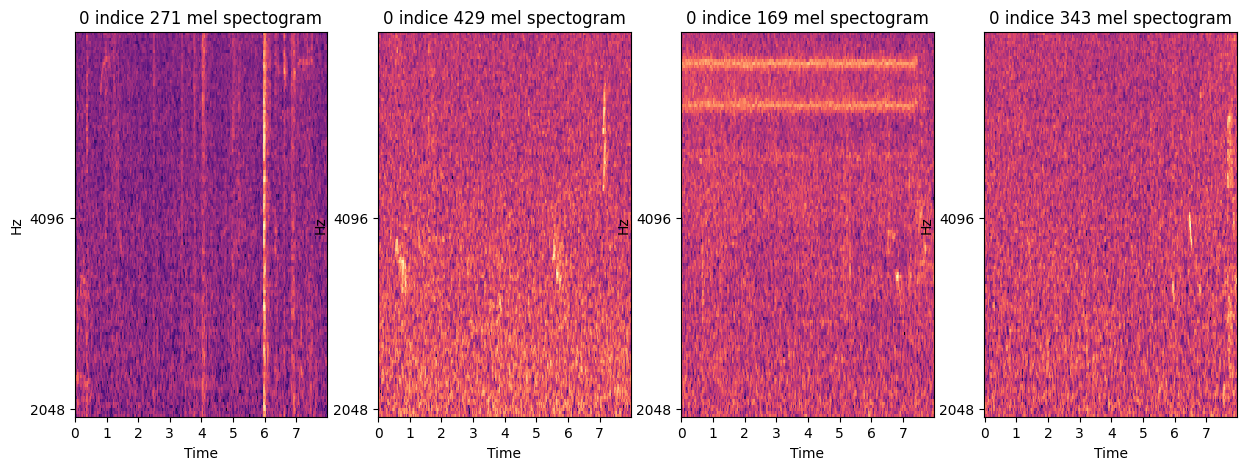

In [ ]:
plot_spectrogram('0')

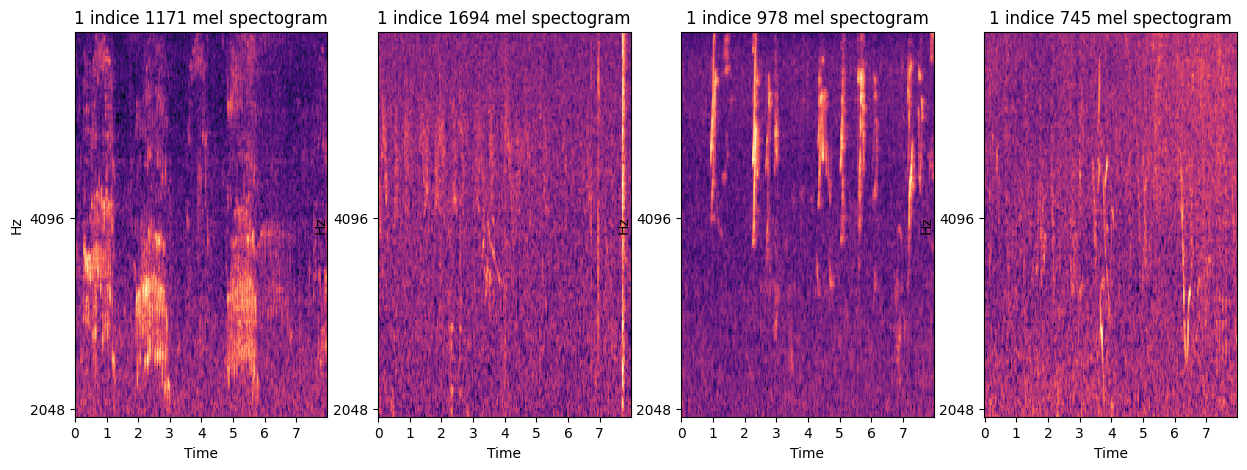

In [ ]:
plot_spectrogram('1')

Look at our distribution

In [ ]:
unique, counts = np.unique(Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 516, '1': 1737}


## Preparation of our dataset
* In  this section,we should convert all our audio into spectrogram
* After we augment our dataset with our augmentation function
* Then we proceed the one hot encoding

## Convert all audio in spectrogram

In [ ]:
X=convert_all_to_image(X)
print('augment-dataset shape',X.shape)

augment-dataset shape (2253, 128, 344)


In [ ]:
X_test=convert_all_to_image(X_test)
print('augment-dataset shape',X_test.shape)

augment-dataset shape (483, 128, 344)


## Data augmentation technique


In [ ]:
def augment_one_spectrogram(spectrogram, true_target):

    if np.random.rand() < 0.5:
      spectrogram = np.flip(spectrogram, axis=1)

    if np.random.rand()<0.5:
      spectrogram = np.fliplr(spectrogram)

    noise = np.random.normal(0, 0.05 * np.max(spectrogram), spectrogram.shape)
    spectrogram += noise


    scale_factor = np.random.uniform(0.8, 1.2)
    spectrogram *= scale_factor

    rotation_angle = np.random.uniform(-20, 20)
    new_spectrogram = np.rot90(spectrogram, k=int(rotation_angle / 90), axes=(0, 1))

    return new_spectrogram,true_target


## Specify augmentation

In [ ]:
def randomly_select_presence(all_spectrograms, targets):

  # Find all the indices where there is a gibbon example
  presence_indices = np.where(targets =='1')[0]

  # Randomly select index
  random_index = random.randint(0,len(presence_indices)-1)

  return all_spectrograms[presence_indices[random_index]]

In [ ]:
def randomly_select_absence(all_spectrograms, targets):

  # Find all the indices where there is a no-gibbon example
  absence_indices = np.where(targets =='0')[0]

  # Randomly select index
  random_index = random.randint(0,len(absence_indices)-1)

  return all_spectrograms[absence_indices[random_index]]

In [ ]:
def generate_new_presence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    presence_spectrogram = randomly_select_presence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(presence_spectrogram,
                                                                      '1')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

In [ ]:
def generate_new_absence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    absence_spectrogram = randomly_select_absence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(absence_spectrogram,
                                                                      '0')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

## Augment positive class

In [ ]:
new_presence, new_targets = generate_new_presence_spectrograms(X, Y, 100)

In [ ]:
print(new_presence.shape)
print(new_targets.shape)

(100, 128, 344)
(100,)


We combine all postive

In [ ]:
X_positive = np.concatenate([X[np.where(Y =='1')], new_presence])
X_positive = np.asarray(X_positive)
print(X_positive.shape)

Y_positive = np.concatenate([Y[np.where(Y =='1')], new_targets])
Y_positive = np.asarray(Y_positive)
print(Y_positive.shape)

(1837, 128, 344)
(1837,)


## Augment negative class

In [ ]:
new_absence, new_targets = generate_new_absence_spectrograms(X, Y, 1200)

In [ ]:
print(new_absence.shape)
print(new_targets.shape)

(1200, 128, 344)
(1200,)


We combine all negative

In [ ]:
X_negatives = np.concatenate([X[np.where(Y =='0')], new_absence])
X_negatives = np.asarray(X_negatives)
print(X_negatives.shape)

Y_negatives = np.concatenate([Y[np.where(Y =='0')], new_targets])
Y_negatives = np.asarray(Y_negatives)
print(Y_negatives.shape)

(1716, 128, 344)
(1716,)


## We reconstruct our dataset

In [ ]:
augmented_X = np.concatenate([X_positive, X_negatives])
augmented_Y = np.concatenate([Y_positive, Y_negatives])

In [ ]:
del X_positive,Y_positive,X_negatives,Y_negatives,new_presence,new_absence,new_targets

## We augment our dataset

In [ ]:
#shape
print('augment-dataset shape',augmented_X.shape)
print('target-dataset shape',augmented_Y.shape)

augment-dataset shape (3553, 128, 344)
target-dataset shape (3553,)


## Look at the new distribution

In [ ]:
unique, counts = np.unique(augmented_Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 1716, '1': 1837}


In [ ]:
unique, counts = np.unique(Y_test, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 85, '1': 398}


## *ONE* HOT ENCODING

In [ ]:
aug_Y = (augmented_Y == '1').astype(int)
aug_Y = to_categorical(aug_Y, num_classes=2)

for testfiles

In [ ]:
Y_test = (Y_test == '1').astype(int)
Y_test = to_categorical(Y_test, num_classes=2)
print(Y_test.shape)

(483, 2)


In [ ]:
#shape
aug_X=np.copy(augmented_X)
print('augment-dataset shape',aug_X.shape)
print('target-dataset shape',aug_Y.shape)

augment-dataset shape (3553, 128, 344)
target-dataset shape (3553, 2)


## Free RAM

In [ ]:
del augmented_X,augmented_Y,X,Y

# Simple approache

## Add channel


In [ ]:
#Shape before
aug_X.shape

(6403, 128, 344)

In [ ]:
X2 = np.reshape(aug_X, (aug_X.shape[0],aug_X.shape[1],aug_X.shape[2],1))

In [ ]:
#Shape after
X2.shape

(6403, 128, 344, 1)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
X_test.shape

(483, 128, 344, 1)

### Function for plot

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Model Training - 2D CNN

### Build the model

We have chosen to apply 4 layers to apply for our neural network by gradually increasing the number of filters to allow the model to capture the maximum number of characteristics while gradually reducing the dimensionality thanks to the pooling layers.
The Dense layer to allow the model to learn complex combinations of features extracted from other layers

In [ ]:
del model2

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras

INPUT_SHAPE=(128,344,1)
# Starting point
model2 = Sequential()

# Create one convolutional layer
model2.add(Conv2D(filters = 32, kernel_size = 3, input_shape = INPUT_SHAPE, activation = 'relu'))

# Create one max pooling layer
model2.add(MaxPool2D(pool_size = 2))

# Create another convolutional layer
model2.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model2.add(MaxPool2D(pool_size=2))

# Create another convolutional layer
model2.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model2.add(MaxPool2D(pool_size=2))

# Create another convolutional layer
model2.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model2.add(MaxPool2D(pool_size=2))


# Add layer for dropout
model2.add(Dropout(0.5))

model2.add(Flatten())

# Here we create 512 fully connected units
model2.add(Dense(units = 512, activation='relu'))

# The output
model2.add(Dense(2, activation = 'softmax'))

# Here we tell the model how to improve/update the weights
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

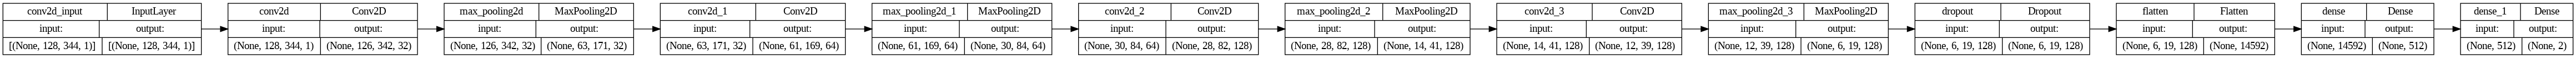

In [17]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 342, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 171, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 169, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 84, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 82, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 41, 128)       0

In [ ]:
history=model2.fit(X2,aug_Y,
           epochs=10,validation_split=0.2,batch_size=64)

Epoch 1/10
81/81 [==============================] - 24s 174ms/step - loss: 0.8907 - accuracy: 0.6634 - val_loss: 0.8894 - val_accuracy: 0.5238
Epoch 2/10
81/81 [==============================] - 12s 142ms/step - loss: 0.4539 - accuracy: 0.8102 - val_loss: 0.5513 - val_accuracy: 0.6628
Epoch 3/10
81/81 [==============================] - 11s 140ms/step - loss: 0.4254 - accuracy: 0.8110 - val_loss: 0.5219 - val_accuracy: 0.6674
Epoch 4/10
81/81 [==============================] - 12s 143ms/step - loss: 0.3885 - accuracy: 0.8243 - val_loss: 0.4859 - val_accuracy: 0.6659
Epoch 5/10
81/81 [==============================] - 11s 140ms/step - loss: 0.3640 - accuracy: 0.8335 - val_loss: 0.3085 - val_accuracy: 0.8017
Epoch 6/10
81/81 [==============================] - 11s 140ms/step - loss: 0.3382 - accuracy: 0.8512 - val_loss: 0.3797 - val_accuracy: 0.8017
Epoch 7/10
81/81 [==============================] - 12s 143ms/step - loss: 0.2910 - accuracy: 0.8731 - val_loss: 0.3098 - val_accuracy: 0.8626

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model2.evaluate(X_test, Y_test)
print(f'Test Loss test: {loss}, Test Accuracy test: {accuracy}')

16/16 [==============================] - 1s 30ms/step - loss: 0.2912 - accuracy: 0.8509
Test Loss test: 0.2911837697029114, Test Accuracy test: 0.850931704044342


In [ ]:
y_pred = model2.predict(X_test)

16/16 [==============================] - 0s 10ms/step


In [ ]:
predictions = np.argmax(y_pred,axis=1)
truth = np.argmax(Y_test,axis=1)
mat=confusion_matrix(truth, predictions)
mat

array([[ 55,  30],
       [ 42, 356]])

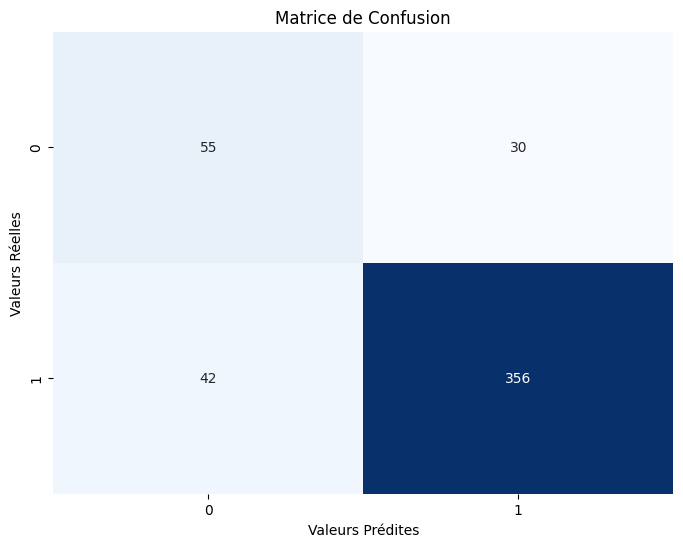

In [ ]:
# Visualisation
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_test= np.argmax(Y_test,axis=1)
y_pred= np.argmax(y_pred,axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print()

Accuracy: 0.85
Precision: 0.92
Recall: 0.89
F1 Score: 0.91



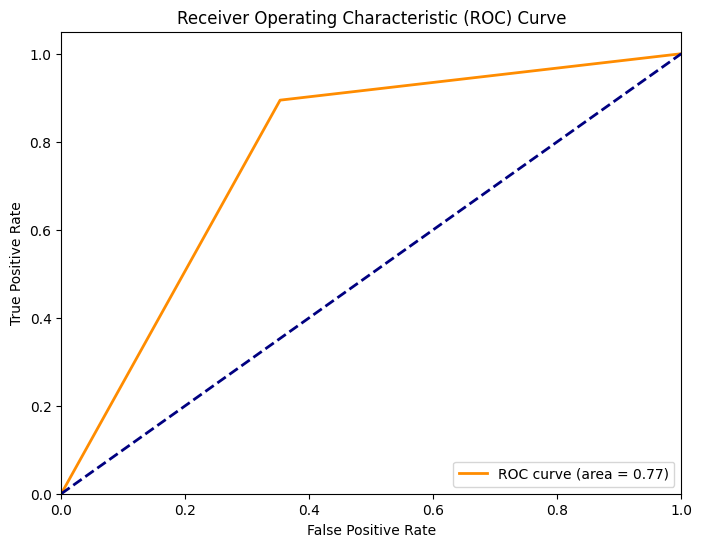

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Model CNN -LSTM

### Build the model

In [ ]:
del model2_1

In [8]:
# Let's go
model2_1 = keras.Sequential()
model2_1.add(layers.Conv2D(filters = 32,kernel_size=4, activation='relu', input_shape=(128, 344, 1)))
model2_1.add(layers.MaxPooling2D(2))
model2_1.add(layers.Conv2D(filters = 64,kernel_size=4, activation='relu'))
model2_1.add(layers.MaxPooling2D(2))
model2_1.add(layers.Conv2D(filters = 64,kernel_size=4, activation='relu'))
model2_1.add(layers.MaxPooling2D(2))

model2_1.add(layers.Reshape((13, 40, 64,1)))


model2_1.add(layers.ConvLSTM2D(16, activation="relu",kernel_size=4,
                            return_sequences=True))
model2_1.add(layers.ConvLSTM2D(32, activation="relu",kernel_size=4,
                            return_sequences=True))
model2_1.add(layers.ConvLSTM2D(64, activation="relu",kernel_size=4))



model2_1.add(layers.Flatten())
model2_1.add(layers.Dense(2, activation="softmax"))


Print the architecture

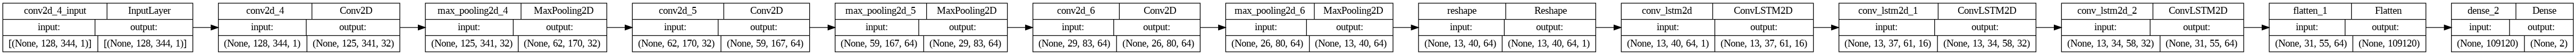

In [9]:
plot_model(model2_1, to_file='model_plot_cnn-lstm.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
model2_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 341, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 170, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 167, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 83, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 80, 64)        65600     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 40, 64)        0

In [ ]:
model2_1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
#seed=42
#filepath="CNN-LSTM.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

history=model2_1.fit(X2,aug_Y,
                    validation_split=0.2,
                    epochs=7,
                    batch_size=64)

Epoch 1/7
81/81 [==============================] - 204s 2s/step - loss: 0.6048 - accuracy: 0.6771 - val_loss: 0.7756 - val_accuracy: 0.5753
Epoch 2/7
81/81 [==============================] - 186s 2s/step - loss: 0.5086 - accuracy: 0.7882 - val_loss: 0.9862 - val_accuracy: 0.3950
Epoch 3/7
81/81 [==============================] - 187s 2s/step - loss: 0.4679 - accuracy: 0.7936 - val_loss: 0.7117 - val_accuracy: 0.5925
Epoch 4/7
81/81 [==============================] - 187s 2s/step - loss: 0.4585 - accuracy: 0.8014 - val_loss: 1.0411 - val_accuracy: 0.3380
Epoch 5/7
81/81 [==============================] - 188s 2s/step - loss: 0.4975 - accuracy: 0.7765 - val_loss: 0.6996 - val_accuracy: 0.5371
Epoch 6/7
81/81 [==============================] - 188s 2s/step - loss: 0.4604 - accuracy: 0.7932 - val_loss: 0.8258 - val_accuracy: 0.5574
Epoch 7/7
81/81 [==============================] - 188s 2s/step - loss: 0.4479 - accuracy: 0.7948 - val_loss: 0.9281 - val_accuracy: 0.4489


In [ ]:
loss, accuracy = model2_1.evaluate(X_test, Y_test)
print(f'Test Loss test: {loss}, Test Accuracy test: {accuracy}')

16/16 [==============================] - 6s 322ms/step - loss: 0.3942 - accuracy: 0.8737
Test Loss test: 0.3941763937473297, Test Accuracy test: 0.8737059831619263


In [ ]:
y_pred = model2_1.predict(X_test)

16/16 [==============================] - 5s 311ms/step


In [ ]:
predictions = np.argmax(y_pred,axis=1)
truth = np.argmax(Y_test,axis=1)
mat=confusion_matrix(truth, predictions)
mat

array([[ 26,  59],
       [  2, 396]])

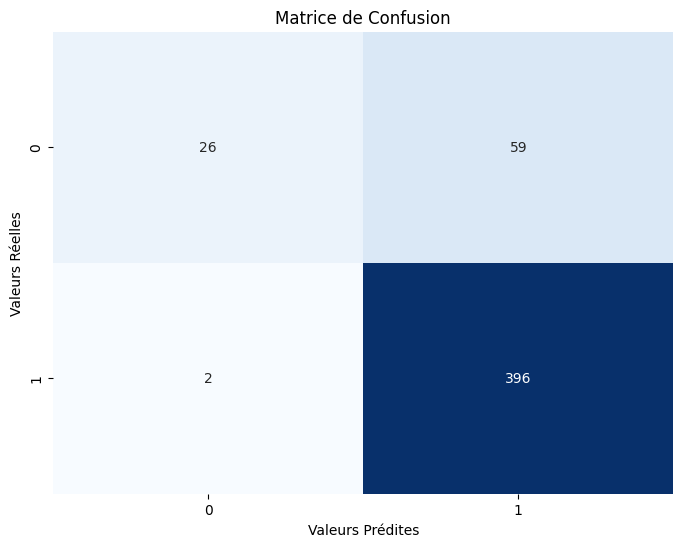

In [ ]:
# Visualisation
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_test= np.argmax(Y_test,axis=1)
y_pred= np.argmax(y_pred,axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print()

Accuracy: 0.87
Precision: 0.87
Recall: 0.99
F1 Score: 0.93



# Transfert Learning approache

Pour l'approche avec des modeles pre-entraines, noous avons quelques modifications a faire sur notre dataset original

### 3 channels for training dataset and test dataset
There we are trying to simulate

In [ ]:
X_stacked = np.expand_dims(aug_X, axis=-1)

In [ ]:
X_stacked.shape

(3553, 128, 344, 1)

In [ ]:
X_new = np.concatenate((np.expand_dims(X_stacked[:,:,:,0], axis=-1),
                        np.expand_dims(X_stacked[:,:,:,0]**2, axis=-1),
                        np.expand_dims(X_stacked[:,:,:,0]/2, axis=-1)), axis=-1)

In [ ]:
X_new.shape

(3553, 128, 344, 3)

In [ ]:
del X_stacked,aug_X

Also for test data

In [ ]:
X_test_dim = np.expand_dims(X_test, axis=-1)

In [ ]:
X_test_dim.shape

(483, 128, 344, 1)

In [ ]:
X_test_dim = np.concatenate((np.expand_dims(X_test_dim[:,:,:,0], axis=-1),
                        np.expand_dims(X_test_dim[:,:,:,0]**2, axis=-1),
                        np.expand_dims(X_test_dim[:,:,:,0]/2, axis=-1)), axis=-1)

In [ ]:
X_test_dim.shape

(483, 128, 344, 3)

In [ ]:
del X_test

### Choose the pretrain model

In [11]:
INPUT_SHAPE = (128,344, 3)
base_model = ResNet50V2(weights="imagenet",
            input_shape=INPUT_SHAPE,
            include_top=False)

94668760/94668760 [==============================] - 4s 0us/step


In [12]:
# Freeze the base_model
base_model.trainable = False

### Split the dataset

## Model Transfert Learning 2DCNN - LSTM

## Build the model

In [13]:
# Create new model on top
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = Conv2D(64, kernel_size = (1,1), activation="relu")(x)
x = layers.Reshape((4, 11, 64,1))(x)
x = ConvLSTM2D(64, activation="relu",kernel_size=2)(x)

x = Flatten()(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
seed=42
filepath="{}_FineTuned.hdf5".format(seed)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [14]:
model.compile(optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

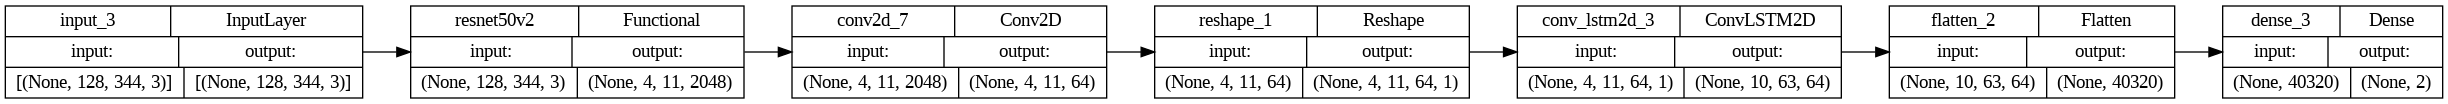

In [15]:
plot_model(model, to_file='model_plot_tl_cnn-lstm.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 344, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 11, 2048)       23564800  
                                                                 
 conv2d (Conv2D)             (None, 4, 11, 64)         131136    
                                                                 
 reshape (Reshape)           (None, 4, 11, 64, 1)      0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 63, 64)        66816     
                                                                 
 flatten (Flatten)           (None, 40320)             0         
                                                                 
 dense (Dense)               (None, 2)                 80642 

In [ ]:
history = model.fit(X_new,aug_Y,
                    validation_split=0.2,batch_size=64,
                    epochs=6,
                    callbacks=callbacks_list,
                    )

Epoch 1/6
45/45 [==============================] - ETA: 0s - loss: 28.9716 - accuracy: 0.6745
Epoch 1: val_loss improved from inf to 9.97500, saving model to 42_FineTuned.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 39s 461ms/step - loss: 28.9716 - accuracy: 0.6745 - val_loss: 9.9750 - val_accuracy: 0.5893
Epoch 2/6
45/45 [==============================] - ETA: 0s - loss: 3.4313 - accuracy: 0.7512
Epoch 2: val_loss improved from 9.97500 to 0.01776, saving model to 42_FineTuned.hdf5
45/45 [==============================] - 13s 283ms/step - loss: 3.4313 - accuracy: 0.7512 - val_loss: 0.0178 - val_accuracy: 0.9972
Epoch 3/6
45/45 [==============================] - ETA: 0s - loss: 2.5986 - accuracy: 0.7850
Epoch 3: val_loss did not improve from 0.01776
45/45 [==============================] - 12s 277ms/step - loss: 2.5986 - accuracy: 0.7850 - val_loss: 3.7882 - val_accuracy: 0.7539
Epoch 4/6
45/45 [==============================] - ETA: 0s - loss: 2.2573 - accuracy: 0.7843
Epoch 4: val_loss did not improve from 0.01776
45/45 [==============================] - 12s 263ms/step - loss: 2.2573 - accuracy: 0.7843 - val_loss: 10.4741 - val_accuracy: 0.4740
Epoch 5/6
4

### Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test_dim, Y_test)
print(f'Test Loss test: {loss}, Test Accuracy test: {accuracy}')

16/16 [==============================] - 6s 158ms/step - loss: 1.3660 - accuracy: 0.8820
Test Loss test: 1.366005539894104, Test Accuracy test: 0.8819875717163086


In [ ]:
y_pred = model.predict(X_test_dim)

16/16 [==============================] - 3s 91ms/step


In [ ]:
predictions = np.argmax(y_pred,axis=1)
truth = np.argmax(Y_test,axis=1)
mat=confusion_matrix(truth, predictions)
mat

array([[ 35,  50],
       [  7, 391]])

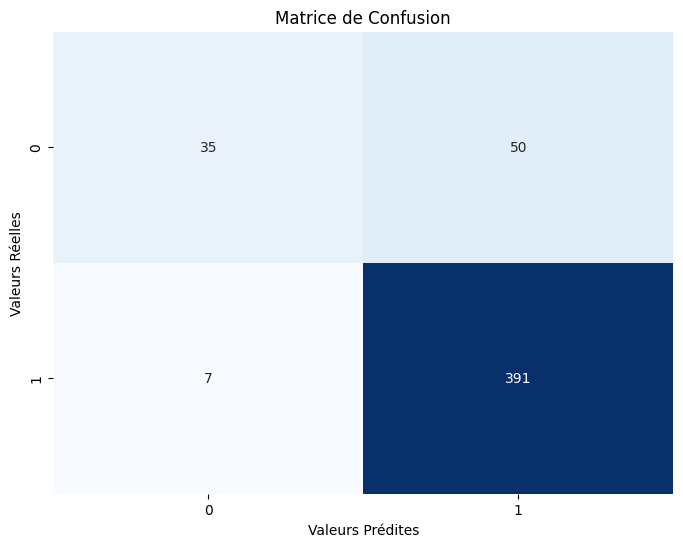

In [ ]:
# Visualisation
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_test= np.argmax(Y_test,axis=1)
y_pred= np.argmax(y_pred,axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print()

Accuracy: 0.88
Precision: 0.89
Recall: 0.98
F1 Score: 0.93

